In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

2024-07-23 08:50:42.902812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 08:50:42.902929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 08:50:43.022075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 256  # Size of the image
BATCH_SIZE = 32   # Batch size for training
EPOCHS = 80      # Number of training epochs
CHANNELS = 3      # Number of color channels (RGB)

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'],
    label_mode='int'
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name=data.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 0 1 0 2 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 2 0 0 1]


In [6]:
len(data)

68

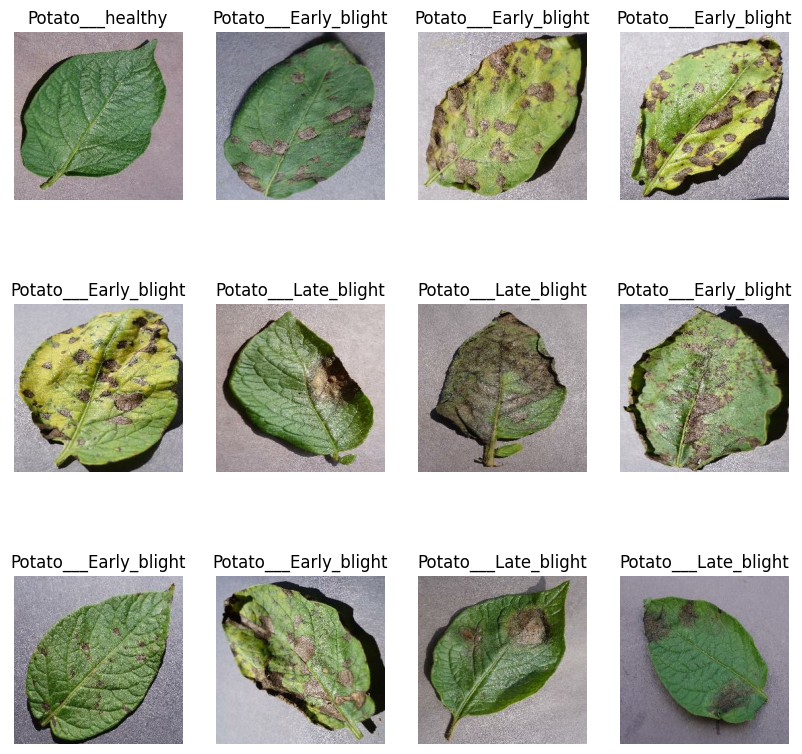

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('int'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

In [8]:
def data_split(data,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):

    data_size=(len(data))
    train_size=int(data_size * train_split)
    test_size=int(data_size * test_split)
    val_size=int(data_size * val_split)

    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)

    train_data=data.take(train_size)
    test_data=data.skip(train_size).take(test_size)
    val_data=data.skip(train_size).skip(test_size)

    return train_data,val_data,test_data

In [9]:
train_data,val_data,test_data=data_split(data)

In [10]:
len(train_data)

54

In [11]:
len(test_data)

6

In [12]:
len(val_data)

8

In [13]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255),
])

In [15]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [16]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
])

model.build(input_shape=(32,256,256,3))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer="adam",loss="SparseCategoricalCrossentropy",metrics=["accuracy"])

In [19]:
history=model.fit(train_data,epochs=35,batch_size=32,verbose=1,validation_data=val_data)

Epoch 1/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.4657 - loss: 0.9521 - val_accuracy: 0.4766 - val_loss: 0.8584
Epoch 2/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.6278 - loss: 0.7480 - val_accuracy: 0.7344 - val_loss: 0.5800
Epoch 3/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7836 - loss: 0.4924 - val_accuracy: 0.8086 - val_loss: 0.4742
Epoch 4/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8454 - loss: 0.3712 - val_accuracy: 0.8750 - val_loss: 0.2998
Epoch 5/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8710 - loss: 0.3165 - val_accuracy: 0.9141 - val_loss: 0.2200
Epoch 6/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8955 - loss: 0.2524 - val_accuracy: 0.9219 - val_loss: 0.2085
Epoch 7/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8848 - loss: 0.2719 - val_accuracy: 0.9375 - val_loss: 0.1723
Epoch 8/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9282 - loss: 0.1759 - val_accuracy: 0.9336 -

In [20]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8187 - loss: 0.8963


[0.9023935198783875, 0.8125]

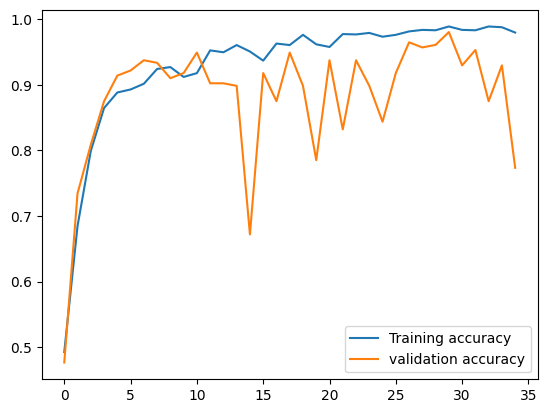

In [21]:
plt.plot(history.history['accuracy'],label='Training accuracy');
plt.plot(history.history['val_accuracy'],label='validation accuracy');
plt.legend();

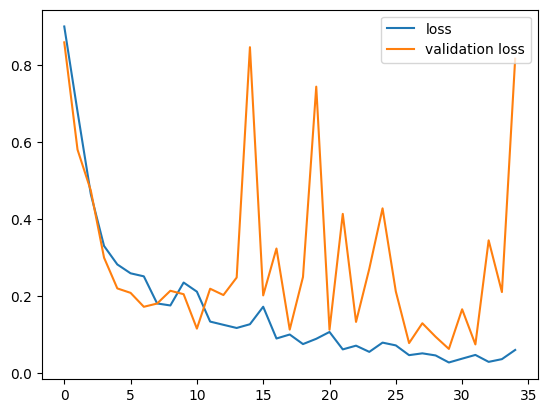

In [22]:
plt.plot(history.history['loss'],label="loss");
plt.plot(history.history['val_loss'],label="validation loss");
plt.legend();

In [23]:
def predict(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_arr=tf.expand_dims(img_arr,0)
    
    prediction=model.predict(img_arr)
    predicted_class=class_name[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


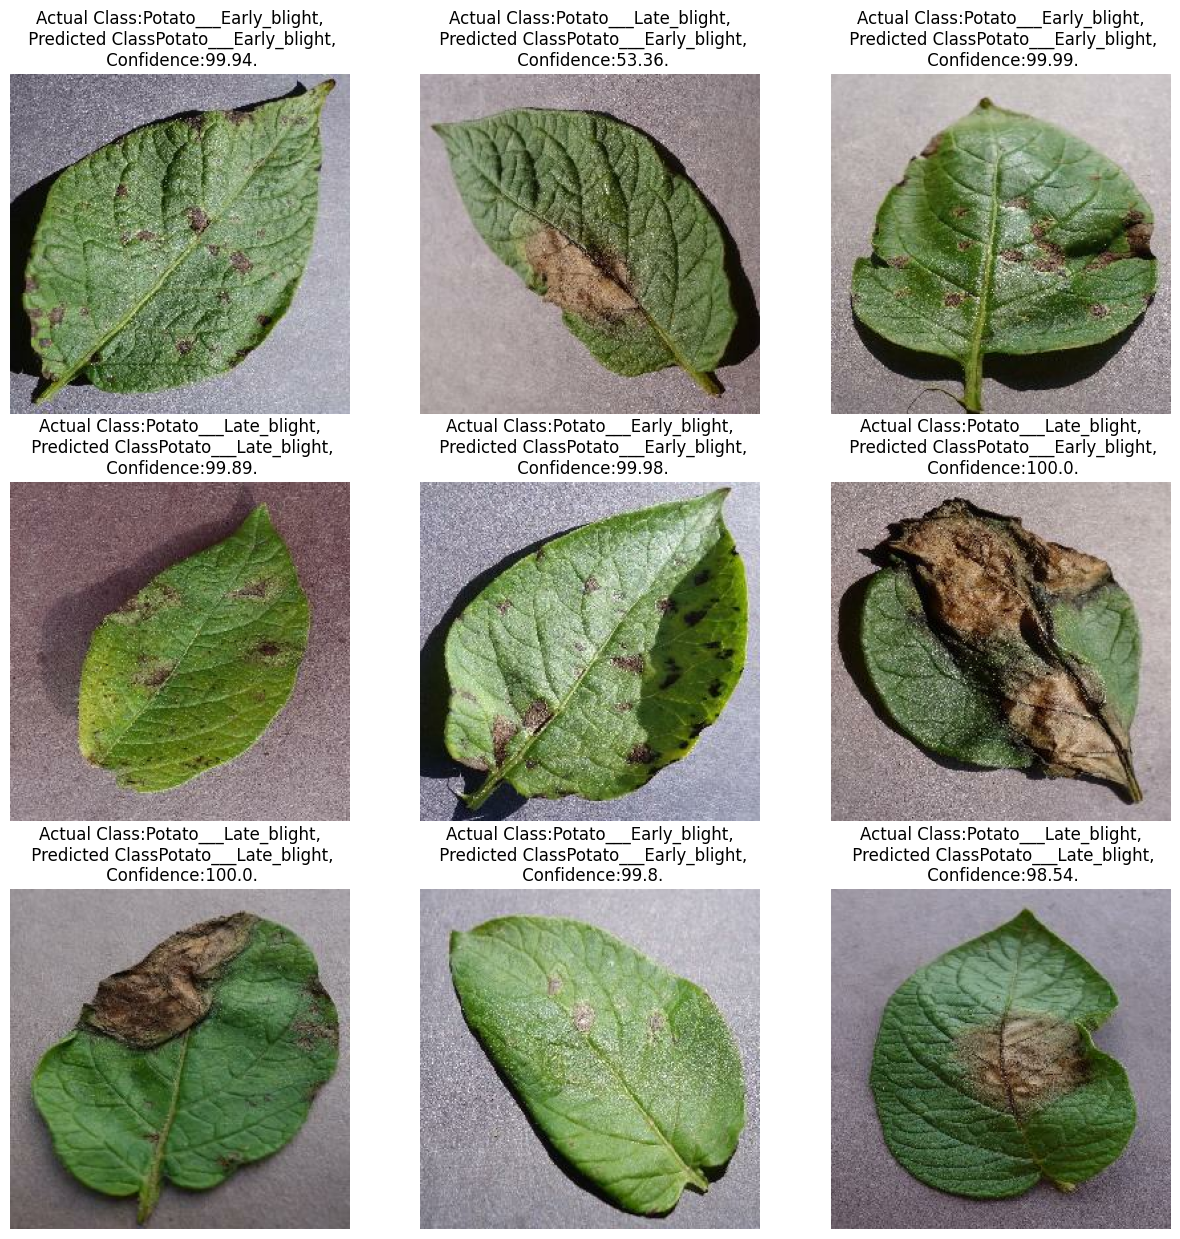

In [24]:
plt.figure(figsize=(15,15))
for image,labels in test_data.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('int'))
        
        actual_class=class_name[labels[i]]
        predicted_class,confidence=predict(model,image[i].numpy())
        
        plt.title(f"Actual Class:{actual_class},\n Predicted Class{predicted_class},\n Confidence:{confidence}.")
        plt.axis("off")

In [25]:
import os

# Directory containing the uploaded image
image_directory = '/kaggle/input/testing/'
uploaded_files = os.listdir(image_directory)
print("Uploaded files:", uploaded_files)

Uploaded files: ['360_F_290979311_vU1c3cYoPzJ3Z6gsrw3s7BiMcRv1WL6H.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


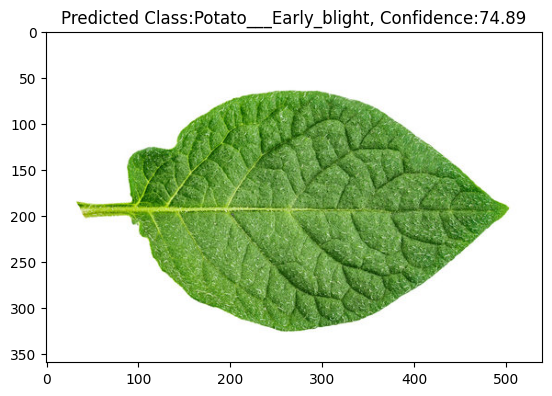

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

image_file_name = uploaded_files[0]
image_path = os.path.join(image_directory, image_file_name)

image = Image.open(image_path)

img_arr = img_to_array(image)
img_arr=tf.expand_dims(img_arr,0)
    
prediction=model.predict(img_arr)
predicted_class=class_name[np.argmax(prediction)]
confidence=round(100*(np.max(prediction)),2)

plt.imshow(image);
plt.title(f"Predicted Class:{predicted_class}, Confidence:{confidence}");